## Homework 8
November 23, 2022<br>
Vivian Lin<br>
ID: 6043749830<br>
Dr. Mohammad Rajati

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from scipy.special import softmax
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def random_split(Xp_data, yp_data, Xn_data, yn_data, test_size):
    """
    Function randomly splits data into train and test sets for both positive and negative cases.
    """
    # Randomly select positive and negative classes as train and test set 
    Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp_data, yp_data, test_size=test_size)
    Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn_data, yn_data, test_size=test_size)

    # Combine the positive and negtaive and make the train and test set
    X_train = pd.concat([Xp_train, Xn_train])
    X_test = pd.concat([Xp_test, Xn_test])
    y_train = pd.concat([yp_train, yn_train])
    y_test = pd.concat([yp_test, yn_test])
    return X_train, X_test, y_train, y_test
    
def calc_auc(X_data, y_data, model):
    """
    Function calculates the AUC of the ROC curve.
    """
    y_score = model.decision_function(X_data)
    fpr, tpr, _ = roc_curve(y_data, y_score, pos_label='M')
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def furthest(X_data, model):
    """
    Function identifies the furthest unlabeled datapoint to deicision boundary.
    """
    dists = model.decision_function(X_data)
    # absolute distance to hyperplane
    abs_dists = np.abs(dists)
    return abs_dists.argsort()[-1]

def closest10(X_data, model):
    """
    Function identifies the closest unlabeled datapoint to deicision boundary.
    """
    dists = model.decision_function(X_data)
    # absolute distance to hyperplane
    abs_dists = np.abs(dists)
    return abs_dists.argsort()[:10]

def find_majority(list_labels, threshold):
    """
    Find majority label of a given list.
    """
    pos_count = 0
    neg_count = 0
    for l in list_labels:
        if l == 'M':
            pos_count += 1
        else:
            neg_count += 1
    if pos_count / len(list_labels) >= threshold:
        return "M"
    return "B"

<b>1. Supervised, Semi-Supervised, and Unsupervised</b><br>
1a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes

In [3]:
cols = []
with open("../data/wdbc.names") as name:
    lines = name.readlines()
    for l in lines:
        if re.match("\t[a-z]+\)", l):
            cols.append(l.split()[1])
attr = ['mn', 'se', 'wr']
header = ['id', 'diagnosis']
for a in attr:
    for c in cols:
        c_name = c + '_' + a
        header.append(c_name)
data = pd.read_csv("../data/wdbc.data", header=None, names=header)
data

,id,diagnosis,radius_mn,texture_mn,perimeter_mn,area_mn,smoothness_mn,compactness_mn,concavity_mn,concave_mn,...,radius_wr,texture_wr,perimeter_wr,area_wr,smoothness_wr,compactness_wr,concavity_wr,concave_wr,symmetry_wr,fractal_wr
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


<b>1b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.</b>

In [4]:
pos = data[data['diagnosis'] == "M"]
Xpos_data = pos.drop(['id', 'diagnosis'], axis=1)
ypos_data = pos['diagnosis']

neg = data[data['diagnosis'] == "B"]
Xneg_data = neg.drop(['id', 'diagnosis'], axis=1)
yneg_data = neg['diagnosis']


<b>1bi) Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.</b>

Best regularization term for run 0 is : {'C': 2.976351441631316}
Best regularization term for run 1 is : {'C': 1.438449888287663}
Best regularization term for run 2 is : {'C': 0.6951927961775606}
Best regularization term for run 3 is : {'C': 2.976351441631316}
Best regularization term for run 4 is : {'C': 1.438449888287663}
Best regularization term for run 5 is : {'C': 6.158482110660261}
Best regularization term for run 6 is : {'C': 6.158482110660261}
Best regularization term for run 7 is : {'C': 2.976351441631316}
Best regularization term for run 8 is : {'C': 1.438449888287663}
Best regularization term for run 9 is : {'C': 0.6951927961775606}
Best regularization term for run 10 is : {'C': 1.438449888287663}
Best regularization term for run 11 is : {'C': 0.3359818286283781}
Best regularization term for run 12 is : {'C': 1.438449888287663}
Best regularization term for run 13 is : {'C': 0.3359818286283781}
Best regularization term for run 14 is : {'C': 2.976351441631316}
Best regularizat

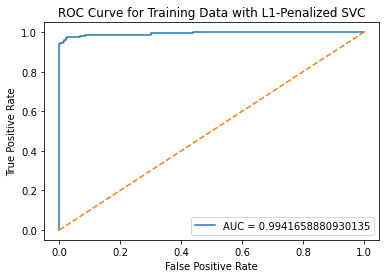

For the test data -- True negative: 71, False positive: 1, False negative: 4, True positive: 39


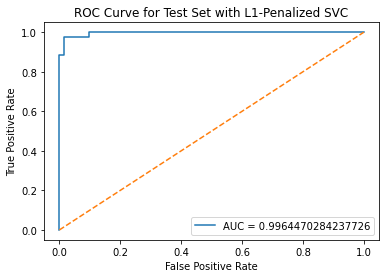

In [5]:
sl_acc_tr, sl_acc_tt = [], []
sl_prec_tr, sl_prec_tt = [], []
sl_rec_tr, sl_rec_tt = [], []
sl_f1_tr, sl_f1_tt = [], []
sl_auc_tr, sl_auc_tt = [], []

C_sl = np.logspace(-3,3,20)
mc = 30

for i in range(mc):
    # Randomly select 20% of positive and negative classes as test set 
    X_train, X_test, y_train, y_test = random_split(Xpos_data, ypos_data, Xneg_data, yneg_data, 0.2)
    
    # Normalize the data
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    # GridSearchCV to determine the best C for l1-penalized SVM
    svc = LinearSVC(penalty='l1', dual=False)
    svc_CV = GridSearchCV(svc, param_grid={"C": C_sl}, cv=StratifiedKFold(5))

    # Fit data
    svc_CV.fit(X_train_sc, y_train)
    print(f"Best regularization term for run {i} is : {svc_CV.best_params_}")

    # Predict training set
    y_pred_svc = svc_CV.predict(X_train_sc)
    sl_acc_tr.append(accuracy_score(y_train, y_pred_svc))
    sl_prec_tr.append(precision_score(y_train, y_pred_svc, pos_label='M'))
    sl_rec_tr.append(recall_score(y_train, y_pred_svc, pos_label='M'))
    sl_f1_tr.append(f1_score(y_train, y_pred_svc, pos_label='M'))
    fpr_tr, tpr_tr, auc_tr = calc_auc(X_train_sc, y_train, svc_CV)
    sl_auc_tr.append(auc_tr)

    # Predict test set
    yhat_svc = svc_CV.predict(X_test_sc)
    sl_acc_tt.append(accuracy_score(y_test, yhat_svc))
    sl_prec_tt.append(precision_score(y_test, yhat_svc, pos_label='M'))
    sl_rec_tt.append(recall_score(y_test, yhat_svc, pos_label='M'))
    sl_f1_tt.append(f1_score(y_test, yhat_svc, pos_label='M'))
    fpr_tt, tpr_tt, auc_tt = calc_auc(X_test_sc, y_test, svc_CV)
    sl_auc_tt.append(auc_tt)

    # Plot the ROC curve and report the confusion matrix for one of the runs.
    if i == mc-1:
        # Training set
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_pred_svc).ravel()
        print(f"For the train data -- True negative: {tn_tr}, False positive: {fp_tr}, False negative: {fn_tr}, True positive: {tp_tr}")
        # Plot the ROC curve and the AUC.
        plt.plot(fpr_tr, tpr_tr, label=f'AUC = {auc_tr}')
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Training Data with L1-Penalized SVC")
        plt.legend()
        plt.show()

        # Test set
        tn_tt, fp_tt, fn_tt, tp_tt = confusion_matrix(y_test, yhat_svc).ravel()
        print(f"For the test data -- True negative: {tn_tt}, False positive: {fp_tt}, False negative: {fn_tt}, True positive: {tp_tt}")
        # Plot the ROC curve and the AUC.
        plt.plot(fpr_tt, tpr_tt, label=f'AUC = {auc_tt}')
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Test Set with L1-Penalized SVC")
        plt.legend()
        plt.show()

In [6]:
scores_sl = pd.DataFrame({"train": [np.mean(sl_acc_tr), np.mean(sl_prec_tr), np.mean(sl_rec_tr), np.mean(sl_f1_tr), np.mean(sl_auc_tr)],
                        "test": [np.mean(sl_acc_tt), np.mean(sl_prec_tt), np.mean(sl_rec_tt), np.mean(sl_f1_tt), np.mean(sl_auc_tt)]},
                        index=['sl_avg_accuracy', 'sl_avg_precision', 'sl_avg_recall', 'sl_avg_f1score', 'sl_avg_auc'])
scores_sl

,train,test
sl_avg_accuracy,0.986050,0.967536
sl_avg_precision,0.992752,0.974763
sl_avg_recall,0.969625,0.937984
sl_avg_f1score,0.981021,0.955351
sl_avg_auc,0.997292,0.992377


<b>1bii) Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.<br>
1biiA) Train an L1-penalized SVM to classify the labeled data. Use normalized data. Choose the penalty parameter using 5 fold cross validation.<br>
1biiB) Find the unlabeled datapoint that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs</b>

Starting to add unlabeled data in for run 0.
Run 0 unlabeled data (0, 30) are all added into (454, 30) and training label (454,).
Best regularization term for run 0 is : {'C': 0.46415888336127775}
Starting to add unlabeled data in for run 1.
Run 1 unlabeled data (0, 30) are all added into (454, 30) and training label (454,).
Best regularization term for run 1 is : {'C': 0.46415888336127775}
Starting to add unlabeled data in for run 2.
Run 2 unlabeled data (0, 30) are all added into (454, 30) and training label (454,).
Best regularization term for run 2 is : {'C': 2.154434690031882}
Starting to add unlabeled data in for run 3.
Run 3 unlabeled data (0, 30) are all added into (454, 30) and training label (454,).
Best regularization term for run 3 is : {'C': 2.154434690031882}
Starting to add unlabeled data in for run 4.
Run 4 unlabeled data (0, 30) are all added into (454, 30) and training label (454,).
Best regularization term for run 4 is : {'C': 2.154434690031882}
Starting to add unlab

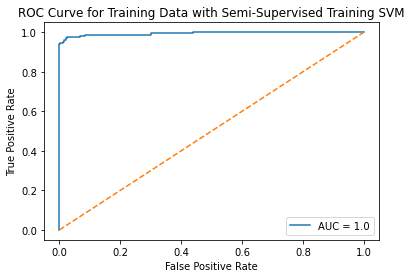

For the test data -- True negative: 68, False positive: 4, False negative: 0, True positive: 43


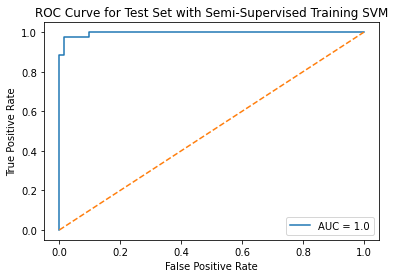

In [20]:
ssl_acc_tr, ssl_acc_tt = [], []
ssl_prec_tr, ssl_prec_tt = [], []
ssl_rec_tr, ssl_rec_tt = [], []
ssl_f1_tr, ssl_f1_tt = [], []
ssl_auc_tr, ssl_auc_tt = [], []

C_ssl = np.logspace(-3,3,10)
mc = 30

for i in range(mc):
    # Randomly select 20% of positive and negative classes as test set 
    X_train, X_test, y_train, y_test = random_split(Xpos_data, ypos_data, Xneg_data, yneg_data, 0.2)

    # Combine the training set to further divide into labeled and unlabeled training sets
    train = pd.concat([X_train, y_train], axis=1)
    tr_lab = train.sample(frac=0.5)
    tr_ulab = train.drop(tr_lab.index)
    # Labeled training
    X_tr_lab = tr_lab.drop(['diagnosis'], axis=1)
    y_tr_lab = tr_lab['diagnosis']
    # Unlabeled training
    x_tr_ulab = tr_ulab.drop(['diagnosis'], axis=1)

    # Normalize labeled training data
    scaler = MinMaxScaler()
    X_tr_lsc = scaler.fit_transform(X_tr_lab)
    X_tr_ulab = scaler.transform(X_tr_lsc)
    X_test_ssl = scaler.transform(X_test)

    # GridSearchCV to determine the best C for l1-penalized SVM
    svc = LinearSVC(penalty='l1', dual=False)
    svc_CV = GridSearchCV(svc, param_grid={"C": C_ssl}, cv=StratifiedKFold(5))

    svc_CV.fit(X_tr_lsc, y_tr_lab)

    print(f"Starting to add unlabeled data in for run {i}.")
    for j in range(len(X_tr_ulab)):
        # Find unlabeled data that is furthest from the decision boundary
        far_idx = furthest(X_tr_ulab, svc_CV)
        ulab_far = X_tr_ulab[far_idx]

        # Predict and add to labeled dataset
        ulab_pred = svc_CV.predict(ulab_far.reshape(1, -1))
        X_tr_lsc = np.append(X_tr_lsc, [ulab_far], axis=0)
        y_tr_lab = y_tr_lab.append(pd.Series(ulab_pred), ignore_index=True)
        
        # Retrain SVC
        svc_CV.fit(X_tr_lsc, y_tr_lab)

        # Remove from unlabeled dataset
        X_tr_ulab = np.delete(X_tr_ulab, far_idx, axis=0)
    print(f"Run {i} unlabeled data {X_tr_ulab.shape} are all added into {X_tr_lsc.shape} and training label {y_tr_lab.shape}.")
    print(f"Best regularization term for run {i} is : {svc_CV.best_params_}")

    # Predict train set
    y_pred_ssl = svc_CV.predict(X_tr_lsc)
    ssl_acc_tr.append(accuracy_score(y_tr_lab, y_pred_ssl))
    ssl_prec_tr.append(precision_score(y_tr_lab, y_pred_ssl, pos_label='M'))
    ssl_rec_tr.append(recall_score(y_tr_lab, y_pred_ssl, pos_label='M'))
    ssl_f1_tr.append(f1_score(y_tr_lab, y_pred_ssl, pos_label='M'))
    fpr_tr_ssl, tpr_tr_ssl, auc_tr_ssl = calc_auc(X_tr_lsc, y_tr_lab, svc_CV)
    ssl_auc_tr.append(auc_tr_ssl)

    # Predict test set
    yhat_ssl = svc_CV.predict(X_test_ssl)
    ssl_acc_tt.append(accuracy_score(y_test, yhat_ssl))
    ssl_prec_tt.append(precision_score(y_test, yhat_ssl, pos_label='M'))
    ssl_rec_tt.append(recall_score(y_test, yhat_ssl, pos_label='M'))
    ssl_f1_tt.append(f1_score(y_test, yhat_ssl, pos_label='M'))
    fpr_tt_ssl, tpr_tt_ssl, auc_tt_ssl = calc_auc(X_test_ssl, yhat_ssl, svc_CV)
    ssl_auc_tt.append(auc_tt_ssl)

    # Plot the ROC curve and report the confusion matrix for one of the runs.
    if i == mc-1:
        # Training set
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_tr_lab, y_pred_ssl).ravel()
        print(f"For the train data -- True negative: {tn_tr}, False positive: {fp_tr}, False negative: {fn_tr}, True positive: {tp_tr}")
        # Plot the ROC curve and the AUC.
        plt.plot(fpr_tr, tpr_tr, label=f'AUC = {auc_tr_ssl}')
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Training Data with Semi-Supervised Training SVM")
        plt.legend()
        plt.show()

        # Test set
        tn_tt, fp_tt, fn_tt, tp_tt = confusion_matrix(y_test, yhat_ssl).ravel()
        print(f"For the test data -- True negative: {tn_tt}, False positive: {fp_tt}, False negative: {fn_tt}, True positive: {tp_tt}")
        # Plot the ROC curve and the AUC.
        plt.plot(fpr_tt, tpr_tt, label=f'AUC = {auc_tt_ssl}')
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Test Set with Semi-Supervised Training SVM")
        plt.legend()
        plt.show()

In [21]:
scores_ssl = pd.DataFrame({"train": [np.mean(ssl_acc_tr), np.mean(ssl_prec_tr), np.mean(ssl_rec_tr), np.mean(ssl_f1_tr), np.mean(ssl_auc_tr)],
                        "test": [np.mean(ssl_acc_tt), np.mean(ssl_prec_tt), np.mean(ssl_rec_tt), np.mean(ssl_f1_tt), np.mean(ssl_auc_tt)]},
                        index=['ssl_avg_accuracy', 'ssl_avg_precision', 'ssl_avg_recall', 'ssl_avg_f1score', 'ssl_avg_auc'])
scores_ssl

,train,test
ssl_avg_accuracy,0.995228,0.969855
ssl_avg_precision,0.998112,0.977577
ssl_avg_recall,0.984268,0.941860
ssl_avg_f1score,0.991091,0.958762
ssl_avg_auc,0.999515,1.000000


<b>1biii) Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.<br>
1biiiA) Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?<br>
1biiiB) Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs<br>
1biiiC) Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.</b>

Ans to 1biiiA)<br>
Finding the global minimum requires KMeans to iterate over all possible clusterings, but the number of iterations is exponential in the size of the data. According this Reference #5, initialize KMeans with n_init = 100 and then choosing the run that gives the lowest error would be a method to avoid algorithm being trapped in a local minimum. To ensure that a global minima is found, algorithm would have to be ran k^n times, but it's not a practical solution, especially for this dataset with n = 569.

Run 0 completed.
Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.
Run 11 completed.
Run 12 completed.
Run 13 completed.
Run 14 completed.
Run 15 completed.
Run 16 completed.
Run 17 completed.
Run 18 completed.
Run 19 completed.
Run 20 completed.
Run 21 completed.
Run 22 completed.
Run 23 completed.
Run 24 completed.
Run 25 completed.
Run 26 completed.
Run 27 completed.
Run 28 completed.
Run 29 completed.
For the train data -- True negative: 284, False positive: 1, False negative: 67, True positive: 102


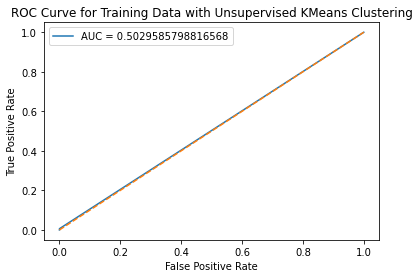

For the test data -- True negative: 72, False positive: 0, False negative: 15, True positive: 28


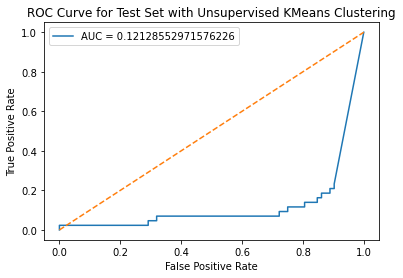

In [7]:
usl_acc_tr, usl_acc_tt = [], []
usl_prec_tr, usl_prec_tt = [], []
usl_rec_tr, usl_rec_tt = [], []
usl_f1_tr, usl_f1_tt = [], []
usl_auc_tr, usl_auc_tt = [], []

C_usl = np.logspace(-3,3,10)
mc = 30

for i in range(mc):
    # Randomly select 20% of positive and negative classes as test set 
    X_train, X_test, y_train, y_test = random_split(Xpos_data, ypos_data, Xneg_data, yneg_data, 0.2)

    # Model with kmeans assuming k = 2
    kmeans = KMeans(n_clusters=2, init='random', n_init=50)

    # Compute clustering and transform X to cluster-distance space to calculate the closest 30 data points
    ypred_kmeans = kmeans.fit_predict(X_train)

    c0_idx = np.argsort(kmeans.transform(X_train)[:,0])[:30]
    c1_idx = np.argsort(kmeans.transform(X_train)[:,1])[:30]

    # Read true labels of data points and take majority poll
    c0_lab = y_train.iloc[c0_idx].value_counts().idxmax()
    c1_lab = y_train.iloc[c1_idx].value_counts().idxmax()

    # Majority poll becomes the label predicted
    ypred_kmeans = np.where(ypred_kmeans == 0, c0_lab, c1_lab)
    usl_acc_tr.append(accuracy_score(y_train, ypred_kmeans))
    usl_prec_tr.append(precision_score(y_train, ypred_kmeans, pos_label='M'))
    usl_rec_tr.append(recall_score(y_train, ypred_kmeans, pos_label='M'))
    usl_f1_tr.append(f1_score(y_train, ypred_kmeans, pos_label='M'))

    # Use distance from cluster centers and pass them through softmax to calculate probabilities
    if c0_lab == 'M':
        cluster_idx = 0
    else:
        cluster_idx = 1
    yscore_usl_tr = softmax(kmeans.transform(X_train)[:,cluster_idx])
    fpr_usl_tr, tpr_usl_tr, _ = roc_curve(y_train, yscore_usl_tr, pos_label='M')
    auc_usl_tr = auc(fpr_usl_tr, tpr_usl_tr)
    usl_auc_tr.append(auc_usl_tr)

    # Classify test data based on proximity 
    yhat_kmeans = kmeans.predict(X_test)
    yhat_kmeans = np.where(yhat_kmeans == 0, c0_lab, c1_lab)
    usl_acc_tt.append(accuracy_score(y_test, yhat_kmeans))
    usl_prec_tt.append(precision_score(y_test, yhat_kmeans, pos_label='M'))
    usl_rec_tt.append(recall_score(y_test, yhat_kmeans, pos_label='M'))
    usl_f1_tt.append(f1_score(y_test, yhat_kmeans, pos_label='M'))
    yscore_usl_tt = softmax(kmeans.transform(X_test)[:,cluster_idx])
    fpr_usl_tt, tpr_usl_tt, _ = roc_curve(y_test, yscore_usl_tt, pos_label='M')
    auc_usl_tt = auc(fpr_usl_tt, tpr_usl_tt)
    usl_auc_tt.append(auc_usl_tt)

    print(f"Run {i} completed.")

    # Plot the ROC curve and report the confusion matrix for one of the runs.
    if i == mc-1:
        # Training set
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, ypred_kmeans).ravel()
        print(f"For the train data -- True negative: {tn_tr}, False positive: {fp_tr}, False negative: {fn_tr}, True positive: {tp_tr}")
        # Plot the ROC curve and the AUC.
        plt.plot(fpr_usl_tr, tpr_usl_tr, label=f'AUC = {auc_usl_tr}')
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Training Data with Unsupervised KMeans Clustering")
        plt.legend()
        plt.show()

        # Test set
        tn_tt, fp_tt, fn_tt, tp_tt = confusion_matrix(y_test, yhat_kmeans).ravel()
        print(f"For the test data -- True negative: {tn_tt}, False positive: {fp_tt}, False negative: {fn_tt}, True positive: {tp_tt}")
        # Plot the ROC curve and the AUC.
        plt.plot(fpr_usl_tt, tpr_usl_tt, label=f'AUC = {auc_usl_tt}')
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Test Set with Unsupervised KMeans Clustering")
        plt.legend()
        plt.show()

In [8]:
scores_usl = pd.DataFrame({"train": [np.mean(usl_acc_tr), np.mean(usl_prec_tr), np.mean(usl_rec_tr), np.mean(usl_f1_tr), np.mean(usl_auc_tr)],
                        "test": [np.mean(usl_acc_tt), np.mean(usl_prec_tt), np.mean(usl_rec_tt), np.mean(usl_f1_tt), np.mean(usl_auc_tt)]},
                        index=['usl_avg_accuracy', 'usl_avg_precision', 'usl_avg_recall', 'usl_avg_f1score', 'usl_avg_auc'])
scores_usl

,train,test
usl_avg_accuracy,0.852349,0.849565
usl_avg_precision,0.992908,0.989854
usl_avg_recall,0.607692,0.603876
usl_avg_f1score,0.753637,0.747797
usl_avg_auc,0.449134,0.143201


<b>1biv) Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clusters have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit_predict method</b>

Ans to 'What is Spectral Clustering?':<br>
Spectral clustering uses eigenvalues of special matrices built from data set to perform low-dimension embedding of affinity matrix between samples, followed by clustering (Reference 7 and 8). Spectral clustering works well for smaller number of clusters and when the structure of individual clusters is highly non-convex (Reference 7 and 8).

In [9]:
sc_acc_tr, sc_acc_tt = [], []
sc_prec_tr, sc_prec_tt = [], []
sc_rec_tr, sc_rec_tt = [], []
sc_f1_tr, sc_f1_tt = [], []
sc_auc_tr, sc_auc_tt = [], []

C_usl = np.logspace(-3,3,10)
mc = 30

for i in range(mc):
    # Randomly select 20% of positive and negative classes as test set 
    X_train, X_test, y_train, y_test = random_split(Xpos_data, ypos_data, Xneg_data, yneg_data, 0.2)

    # Model with Spectral Clustering using RBF kernel with gamma = 1, assuming k = 2
    spec_clus = SpectralClustering(n_clusters=2, n_init=50, gamma=1.0, affinity='rbf')
    # Get the labels of each cluster
    ypred_sclus = spec_clus.fit_predict(X_train)
    labels = spec_clus.labels_

    c0_labs = []
    c1_labs = []

    y_train.reset_index(drop=True, inplace=True)
    # Obtain all labels such that majority polling can be done on predicted labels
    for j in range(len(labels)):
        if labels[j] == 0:
            c0_labs.append(y_train[j])
        else:
            c1_labs.append(y_train[j])

    c0_label = find_majority(c0_labs, 0.5)
    # Prevent division of zero by checking if there are two clusters
    if len(c1_labs) == 0:
        print("Only one cluster, only take majority of cluster 0.")
        c1_label = None
    else:
        print("Two clusters present.")
        c1_label = find_majority(c1_labs, 0.5)

    # Spectral clustering predicted labels based on majority polling of all points in cluster.
    ypred_sclus = np.where(ypred_sclus == 0, c0_label, c1_label)
    sc_acc_tr.append(accuracy_score(y_train, ypred_sclus))
    sc_prec_tr.append(precision_score(y_train, ypred_sclus, pos_label='M'))
    sc_rec_tr.append(recall_score(y_train, ypred_sclus, pos_label='M'))
    sc_f1_tr.append(f1_score(y_train, ypred_sclus, pos_label='M'))

    # Using Neighbors classifer to predict test data
    clf = KNeighborsClassifier()
    clf.fit(X_train, ypred_sclus)
    yhat_sclus = clf.predict(X_test)
    sc_acc_tt.append(accuracy_score(y_test, yhat_sclus))
    sc_prec_tt.append(precision_score(y_test, yhat_sclus, pos_label='M'))
    sc_rec_tt.append(recall_score(y_test, yhat_sclus, pos_label='M'))
    sc_f1_tt.append(f1_score(y_test, yhat_sclus, pos_label='M'))

    print(f"Run {i} completed.")

    # Report the confusion matrix for one of the runs.
    if i == mc-1:
        # Training set
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, ypred_sclus).ravel()
        print(f"For the train data -- True negative: {tn_tr}, False positive: {fp_tr}, False negative: {fn_tr}, True positive: {tp_tr}")

        # Test set
        tn_tt, fp_tt, fn_tt, tp_tt = confusion_matrix(y_test, yhat_sclus).ravel()
        print(f"For the test data -- True negative: {tn_tt}, False positive: {fp_tt}, False negative: {fn_tt}, True positive: {tp_tt}")

Only one cluster, only take majority of cluster 0.
Run 0 completed.
Only one cluster, only take majority of cluster 0.
Run 1 completed.
Two clusters present.
Run 2 completed.
Only one cluster, only take majority of cluster 0.
Run 3 completed.
Two clusters present.
Run 4 completed.
Two clusters present.
Run 5 completed.
Two clusters present.
Run 6 completed.
Two clusters present.
Run 7 completed.
Only one cluster, only take majority of cluster 0.
Run 8 completed.
Only one cluster, only take majority of cluster 0.
Run 9 completed.
Only one cluster, only take majority of cluster 0.
Run 10 completed.
Two clusters present.
Run 11 completed.
Only one cluster, only take majority of cluster 0.
Run 12 completed.
Only one cluster, only take majority of cluster 0.
Run 13 completed.
Only one cluster, only take majority of cluster 0.
Run 14 completed.
Two clusters present.
Run 15 completed.
Only one cluster, only take majority of cluster 0.
Run 16 completed.
Two clusters present.
Run 17 completed.


In [10]:
scores_sc = pd.DataFrame({"train": [np.mean(sc_acc_tr), np.mean(sc_prec_tr), np.mean(sc_rec_tr), np.mean(sc_f1_tr), np.mean(sc_auc_tr)],
                        "test": [np.mean(sc_acc_tt), np.mean(sc_prec_tt), np.mean(sc_rec_tt), np.mean(sc_f1_tt), np.mean(sc_auc_tt)]},
                        index=['sc_avg_accuracy', 'sc_avg_precision', 'sc_avg_recall', 'sc_avg_f1score', 'sc_avg_auc'])
scores_sc

,train,test
sc_avg_accuracy,0.628047,0.626087
sc_avg_precision,0.216667,0.000000
sc_avg_recall,0.001775,0.000000
sc_avg_f1score,0.003518,0.000000
sc_avg_auc,NaN,NaN


<b>1bv) One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled. One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.</b>

In [22]:
scores = pd.concat([scores_sl, scores_ssl, scores_usl, scores_sc])
scores

,train,test
sl_avg_accuracy,0.986050,0.967536
sl_avg_precision,0.992752,0.974763
sl_avg_recall,0.969625,0.937984
sl_avg_f1score,0.981021,0.955351
sl_avg_auc,0.997292,0.992377
ssl_avg_accuracy,0.995228,0.969855
ssl_avg_precision,0.998112,0.977577
ssl_avg_recall,0.984268,0.941860
ssl_avg_f1score,0.991091,0.958762
ssl_avg_auc,0.999515,1.000000


Conclusion: There is not much different between supervised learning and semi-supervised learning, but for unsupervised learning, the accuracy, recall, f1-score and auc all dropped significantly. In Spectral clustering, test precision, recall and f1=score are as low as 0, and accuracy is very close to 0.5, which indicates this method is almost like 0.5-0.5 guessing compared to other methods.

<b>2. Active Learning Using SVMs<br>
2a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem. </b>

In [12]:
data2 = pd.read_csv("../data/data_banknote_authentication.txt", header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
data2

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [13]:
# Choose 472 data points randomly as test set
test = data2.sample(n=472, random_state=42)
train = data2.drop(test.index)
print(train.shape, test.shape)

X_test = test.drop(['class'], axis=1)
y_test = test['class']

(900, 5) (472, 5)


<b>2b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.<br>
2bi) Traina SVM with a pool of 10 randomly selected datapoints from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.</b>

In [14]:
pl_test_err = {}

mc = 50
repeat = train.shape[0] // 10
C_sl = np.logspace(-3,3,20)

for i in range(mc):
    err_val = []
    for j in range(repeat):
        if j == 0:
            # For first run only
            subsamp = train.sample(n=10, random_state=42)
        else:
            # Append to subsamp
            subsamp = subsamp.append(remain_tr.sample(n=10, random_state=42))
        # Sample without replacement
        remain_tr = train.drop(subsamp.index)

        # Get the X and y of training set of the subsample
        X_train = subsamp.drop(['class'], axis=1)
        y_train = subsamp['class']

        # GridSearchCV to determine the best C for l1-penalized SVM
        svc = LinearSVC(penalty='l1', dual=False)
        svc_CV = GridSearchCV(svc, param_grid={"C": C_sl}, cv=StratifiedKFold(5))

        # Fit data and predict
        svc_CV.fit(X_train, y_train)
        yhat_pl = svc_CV.predict(X_test)

        # Calculate test error
        err = 1 - accuracy_score(y_test, yhat_pl)
        err_val.append(err)

    pl_test_err[i] = err_val
    print(f"Run {i}: {len(err_val)} errors calculated.")

Run 0: 90 errors calculated.
Run 1: 90 errors calculated.
Run 2: 90 errors calculated.
Run 3: 90 errors calculated.
Run 4: 90 errors calculated.
Run 5: 90 errors calculated.
Run 6: 90 errors calculated.
Run 7: 90 errors calculated.
Run 8: 90 errors calculated.
Run 9: 90 errors calculated.
Run 10: 90 errors calculated.
Run 11: 90 errors calculated.
Run 12: 90 errors calculated.
Run 13: 90 errors calculated.
Run 14: 90 errors calculated.
Run 15: 90 errors calculated.
Run 16: 90 errors calculated.
Run 17: 90 errors calculated.
Run 18: 90 errors calculated.
Run 19: 90 errors calculated.
Run 20: 90 errors calculated.
Run 21: 90 errors calculated.
Run 22: 90 errors calculated.
Run 23: 90 errors calculated.
Run 24: 90 errors calculated.
Run 25: 90 errors calculated.
Run 26: 90 errors calculated.
Run 27: 90 errors calculated.
Run 28: 90 errors calculated.
Run 29: 90 errors calculated.
Run 30: 90 errors calculated.
Run 31: 90 errors calculated.
Run 32: 90 errors calculated.
Run 33: 90 errors ca

<b>2bii) Traina SVM with a pool of 10 randomly selected datapoints from the training set (if all selected data points are from one class, select another 10 data points randomly) using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.</b>

In [15]:
al_test_err = {}

mc = 50
repeat = train.shape[0] // 10
C_sl = np.logspace(-3,3,20)

for i in range(mc):
    err_val = []
    for j in range(repeat):
        if j == 0:
            # For first run only
            subsamp = train.sample(n=10, random_state=42)
            # Check if subsample contains only one class
            if ((subsamp['class'] == subsamp['class'].iloc[0]).all()):
                print("Subsample contains only one class, adding random 10 sampels into subsample.")
                subsamp.append(remain_train.sample(n=10, random_state=42))
        else:
            # Select 10 data points closest to the hyperplane
            remain_X = remain_train.drop(['class'], axis=1)
            close_idx = closest10(remain_X, svc_CV)
            subsamp = subsamp.append(remain_train.iloc[close_idx])
        # Sample without replacement
        remain_train = train.drop(subsamp.index)

        # Get the X and y of training set of the subsample
        X_train = subsamp.drop(['class'], axis=1)
        y_train = subsamp['class']

        # GridSearchCV to determine the best C for l1-penalized SVM
        svc = LinearSVC(penalty='l1', dual=False)
        svc_CV = GridSearchCV(svc, param_grid={"C": C_sl}, cv=StratifiedKFold(5))

        # Fit data and predict
        svc_CV.fit(X_train, y_train)
        yhat_pl = svc_CV.predict(X_test)

        # Calculate test error
        err = 1 - accuracy_score(y_test, yhat_pl)
        err_val.append(err)

    al_test_err[i] = err_val
    print(f"Run {i}: {len(err_val)} errors calculated.")

Run 0: 90 errors calculated.
Run 1: 90 errors calculated.
Run 2: 90 errors calculated.
Run 3: 90 errors calculated.
Run 4: 90 errors calculated.
Run 5: 90 errors calculated.
Run 6: 90 errors calculated.
Run 7: 90 errors calculated.
Run 8: 90 errors calculated.
Run 9: 90 errors calculated.
Run 10: 90 errors calculated.
Run 11: 90 errors calculated.
Run 12: 90 errors calculated.
Run 13: 90 errors calculated.
Run 14: 90 errors calculated.
Run 15: 90 errors calculated.
Run 16: 90 errors calculated.
Run 17: 90 errors calculated.
Run 18: 90 errors calculated.
Run 19: 90 errors calculated.
Run 20: 90 errors calculated.
Run 21: 90 errors calculated.
Run 22: 90 errors calculated.
Run 23: 90 errors calculated.
Run 24: 90 errors calculated.
Run 25: 90 errors calculated.
Run 26: 90 errors calculated.
Run 27: 90 errors calculated.
Run 28: 90 errors calculated.
Run 29: 90 errors calculated.
Run 30: 90 errors calculated.
Run 31: 90 errors calculated.
Run 32: 90 errors calculated.
Run 33: 90 errors ca

<b>2c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.</b>

In [16]:
pl = pd.DataFrame.from_dict(pl_test_err)
pl['p_average'] = pl.mean(axis=1)
pl

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,p_average
0,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,...,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966
1,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,...,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898
2,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,...,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254,0.040254
3,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,...,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898
4,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,...,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508,0.080508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
86,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
87,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
88,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593


In [17]:
al = pd.DataFrame.from_dict(al_test_err)
al['a_average'] = al.mean(axis=1)
al

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,a_average
0,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,...,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966,0.177966
1,0.012712,0.012712,0.019068,0.019068,0.019068,0.019068,0.019068,0.016949,0.016949,0.012712,...,0.012712,0.012712,0.012712,0.012712,0.031780,0.029661,0.014831,0.014831,0.012712,0.015975
2,0.021186,0.021186,0.125000,0.078390,0.023305,0.125000,0.125000,0.016949,0.016949,0.021186,...,0.021186,0.021186,0.021186,0.021186,0.014831,0.131356,0.014831,0.014831,0.021186,0.040381
3,0.010593,0.010593,0.010593,0.012712,0.010593,0.010593,0.010593,0.008475,0.008475,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.010593,0.011186
4,0.010593,0.010593,0.021186,0.008475,0.006356,0.021186,0.021186,0.010593,0.010593,0.008475,...,0.010593,0.010593,0.010593,0.010593,0.008475,0.012712,0.012712,0.010593,0.010593,0.011737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.014831,0.014831,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.014831,0.010593,0.011441
86,0.010593,0.010593,0.012712,0.010593,0.010593,0.012712,0.012712,0.014831,0.014831,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.014831,0.010593,0.010593,0.014831,0.010593,0.011483
87,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.014831,0.014831,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.014831,0.014831,0.010593,0.011610
88,0.010593,0.010593,0.012712,0.010593,0.010593,0.012712,0.012712,0.014831,0.014831,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.014831,0.010593,0.014831,0.014831,0.010593,0.011780


In [18]:
err = pd.concat([pl['p_average'], al['a_average']], axis=1)
err.reset_index(inplace=True)
err['index'] = err['index'] + 1
err.rename(columns={'index': 'tr_inst', 'p_average': 'passive_learning', 'a_average': 'active_learning'}, inplace=True)
err

,tr_inst,passive_learning,active_learning
0,1,0.177966,0.177966
1,2,0.033898,0.015975
2,3,0.040254,0.040381
3,4,0.033898,0.011186
4,5,0.080508,0.011737
...,...,...,...
85,86,0.010593,0.011441
86,87,0.010593,0.011483
87,88,0.010593,0.011610
88,89,0.010593,0.011780


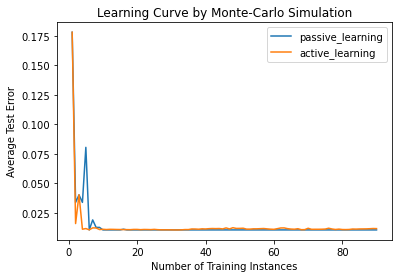

In [19]:
# Plot average test error vs number of instances for both passive and active learning
err.plot(x='tr_inst', y=['passive_learning', 'active_learning'])
plt.xlabel("Number of Training Instances")
plt.ylabel("Average Test Error")
plt.title("Learning Curve by Monte-Carlo Simulation")
plt.show()

Conclusion: Active learning reaches minimum test error at a lower training instance number than passive learning.

### References
1. https://scikit-learn.org/stable/modules/model_evaluation.html<br>
2. https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html<br>
3. https://stackoverflow.com/questions/41443118/select-5-data-points-closest-to-svm-hyperlane<br>
4. https://stats.stackexchange.com/questions/48757/why-doesnt-k-means-give-the-global-minimum<br>
5. https://stackoverflow.com/questions/43789602/avoiding-local-minima-when-using-kmeans<br>
6. https://stackoverflow.com/questions/53790832/how-to-get-n-numbers-of-data-points-which-are-nearest-from-a-clusters-center<br>
7. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html<br>
8. https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering<br>